(https://www.kaggle.com/c/ashrae-energy-prediction/)

# ASRAE - Modeling

In [34]:
import numpy as np
import pandas as pd


import seaborn as sns
import plotly as plt
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from math import sqrt

import glob

import pandas_profiling as ppf
import sweetviz as sv
import missingno as msno

import pprint
import datetime
from math import sqrt

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from prophet import Prophet

import xgboost as xgb

import pmdarima as pm
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing as ppc
from pmdarima import arima
from pmdarima.arima import ndiffs
from pmdarima.arima import ADFTest

print("pmdarima version: %s" % pm.__version__)

import tools as tl

sns.set(rc={'figure.figsize':(30,20)})

pd.options.display.float_format = '{:.2f}'.format

plt.rcParams.update({'font.size': 22})
sns.set(font_scale = 2)

pmdarima version: 1.8.2


In [32]:
print(xgboost.__version__)

1.4.2


In [2]:
pd.options.plotting.backend = "matplotlib"

In [3]:
pwd

'C:\\Users\\Mike\\Google Drive\\Code\\Springboard_Capstone_Energy'

In [4]:
# See Building Statistics for missing data
df_stats = pd.read_csv('.//data_clean//building_reading_stats.csv')
df_stats

,file_name,building,meter,len_train,len_zero,per_data,category,corr_meter_to_airtemp,corr_meter_to_airtemp_wknd,corr_meter_to_airtemp_wkdy,corr_meter_to_airtemp_winter,corr_meter_to_airtemp_spring,corr_meter_to_airtemp_summer,corr_meter_to_airtemp_fall,square_feet,floor_count
0,1448_0.pkl,1448,0,7452,0,100.00,Office,-0.28,-0.20,-0.32,-0.22,-0.29,-0.14,-0.27,92271,-1
1,1447_0.pkl,1447,0,7471,0,100.00,Lodging/residential,0.04,0.00,0.05,0.25,0.03,0.15,0.35,29775,-1
2,1445_0.pkl,1445,0,7449,0,100.00,Education,-0.33,-0.29,-0.35,-0.16,-0.33,0.33,-0.18,4298,-1
3,1443_0.pkl,1443,0,7472,0,100.00,Education,-0.06,-0.05,-0.06,-0.05,-0.14,0.08,0.11,40311,-1
4,1442_0.pkl,1442,0,7472,0,100.00,Public services,0.05,0.18,0.05,-0.14,-0.04,-0.10,0.13,99541,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,1250_2.pkl,1250,2,8784,8536,2.82,Education,-0.16,-0.16,-0.16,0.12,NaN,NaN,NaN,232139,-1
2376,279_3.pkl,279,3,8783,8732,0.58,Education,0.00,-0.00,0.01,NaN,0.05,NaN,NaN,49384,-1
2377,287_3.pkl,287,3,8783,8740,0.49,Office,0.09,0.04,0.10,NaN,NaN,0.03,0.08,33713,-1
2378,1022_1.pkl,1022,1,8774,8766,0.09,Education,-0.01,-0.01,-0.01,0.03,-0.02,NaN,NaN,84346,2


In [5]:
# Modeling Choices
# Buildings with 1

In [6]:
# These represent buildings that are in top, mid and lower in square footage
lrg = [869, 1148, 375, 365, 269]
med = [1063, 1309, 991, 144, 693]
sm = [846, 621, 822, 816, 44]

# 0: Electricity 1: chilledwater 2: steam 3: hotwater

In [7]:
df_stats[(df_stats['building'] == 1148) & df_stats['meter'] == 1]

,file_name,building,meter,len_train,len_zero,per_data,category,corr_meter_to_airtemp,corr_meter_to_airtemp_wknd,corr_meter_to_airtemp_wkdy,corr_meter_to_airtemp_winter,corr_meter_to_airtemp_spring,corr_meter_to_airtemp_summer,corr_meter_to_airtemp_fall,square_feet,floor_count
194,1148_1.pkl,1148,1,8784,0,100.00,Office,0.78,0.79,0.79,0.21,0.74,0.45,0.76,861524,-1


In [8]:
# Examine building choices
df_stats[df_stats['building'] == 1148]

,file_name,building,meter,len_train,len_zero,per_data,category,corr_meter_to_airtemp,corr_meter_to_airtemp_wknd,corr_meter_to_airtemp_wkdy,corr_meter_to_airtemp_winter,corr_meter_to_airtemp_spring,corr_meter_to_airtemp_summer,corr_meter_to_airtemp_fall,square_feet,floor_count
193,1148_0.pkl,1148,0,8663,0,100.00,Office,-0.02,0.15,-0.04,-0.20,-0.11,-0.08,-0.08,861524,-1
194,1148_1.pkl,1148,1,8784,0,100.00,Office,0.78,0.79,0.79,0.21,0.74,0.45,0.76,861524,-1
902,1148_2.pkl,1148,2,8784,2,99.98,Office,-0.88,-0.86,-0.88,-0.83,-0.85,-0.43,-0.44,861524,-1


### Build list of files to include

In [9]:
# Get only the train data
direct = glob.glob('.\\data_clean\\buildings_by_meter\\' + '*.pkl')

directory = '.\\data_clean\\buildings_by_meter\\'
ext = '.pkl'

bld_mtr = ['1148_0']
files = []

# Build File names
for bm in bld_mtr:
    file_n = directory + bm + ext
    files.append(file_n)
        
files

['.\\data_clean\\buildings_by_meter\\1148_0.pkl']

# 1 - Build Model - ARIMA

-----------------------------------------------------------------------------
     building  meter  per_data category  square_feet  corr_meter_to_airtemp
193      1148      0    100.00   Office       861524                  -0.02
Data Size:  120
Train Size:  30
Offset:  0


DATA
Date Start: 
2016-01-01 00:00:00
Date End: 
2016-04-29 00:00:00


TRAIN
Date Start: 
2016-01-01 00:00:00
Date End: 
2016-03-30 00:00:00


TEST
Date Start: 
2016-03-31 00:00:00
Date End: 
2016-04-29 00:00:00


ARIMA Model: 
Model Fit: 


            ARIMA_predict  meter_reading
timestamp                               
2016-03-31       24604.29       24279.98
2016-04-01       23836.53       23935.14
2016-04-02       20887.30       19600.50
2016-04-03       20827.55       19399.49
2016-04-04       23308.38       24457.55
2016-04-05       23250.84       24722.57
2016-04-06       23303.48       24513.10
2016-04-07       23310.15       24438.12
2016-04-08       22904.39       24034.87
2016-04-09       21268.71       

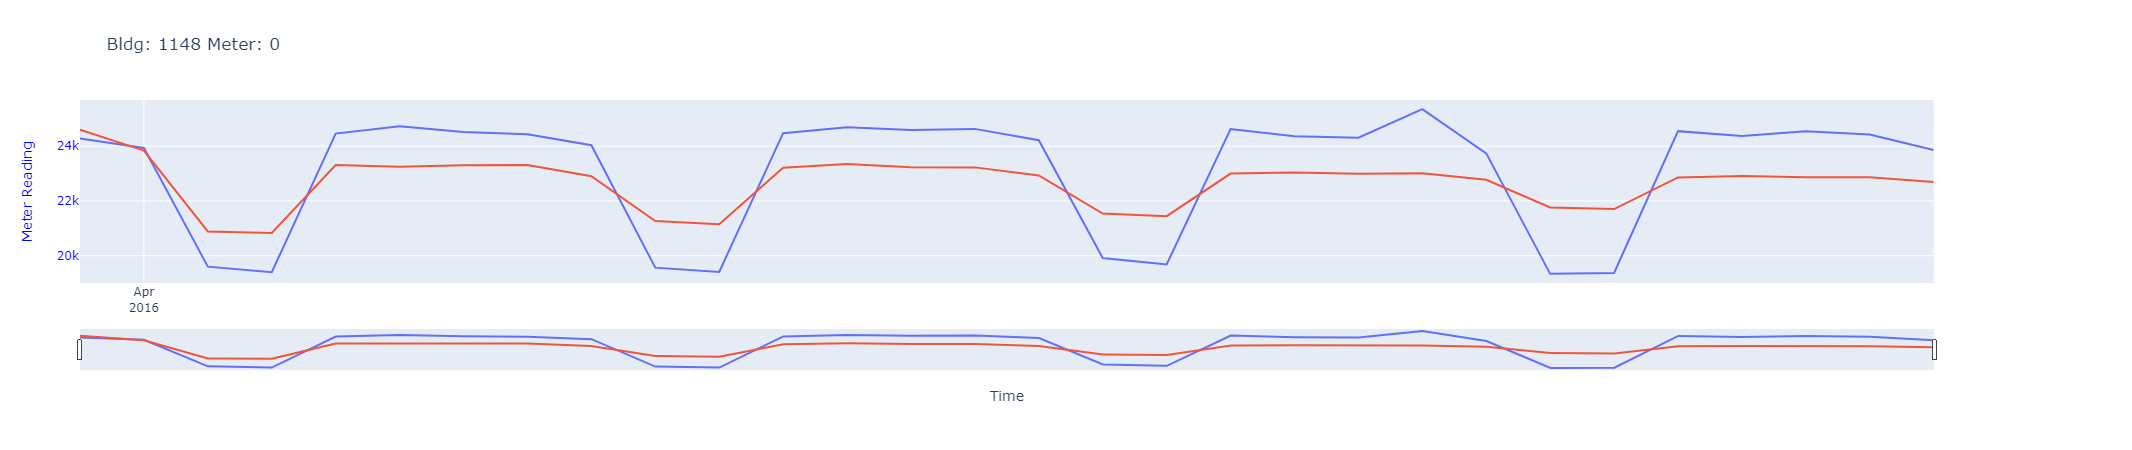

Data Size:  120
Train Size:  30
Offset:  30


DATA
Date Start: 
2016-01-31 00:00:00
Date End: 
2016-05-29 00:00:00


TRAIN
Date Start: 
2016-01-31 00:00:00
Date End: 
2016-04-29 00:00:00


TEST
Date Start: 
2016-04-30 00:00:00
Date End: 
2016-05-29 00:00:00


ARIMA Model: 
Model Fit: 


            ARIMA_predict  meter_reading
timestamp                               
2016-04-30       19366.48       19383.56
2016-05-01       19277.64       19365.60
2016-05-02       24569.01       24036.10
2016-05-03       24454.52       24384.88
2016-05-04       24625.82       24429.16
2016-05-05       24482.92       24529.90
2016-05-06       23887.25       24288.43
2016-05-07       19525.48       19906.22
2016-05-08       19395.27       19879.11
2016-05-09       24557.35       24300.71
2016-05-10       24382.00       23913.94
2016-05-11       24526.37       23893.83
2016-05-12       24531.18       23689.35
2016-05-13       23852.48       23269.51
2016-05-14       19383.85       19039.44
2016-05-15     

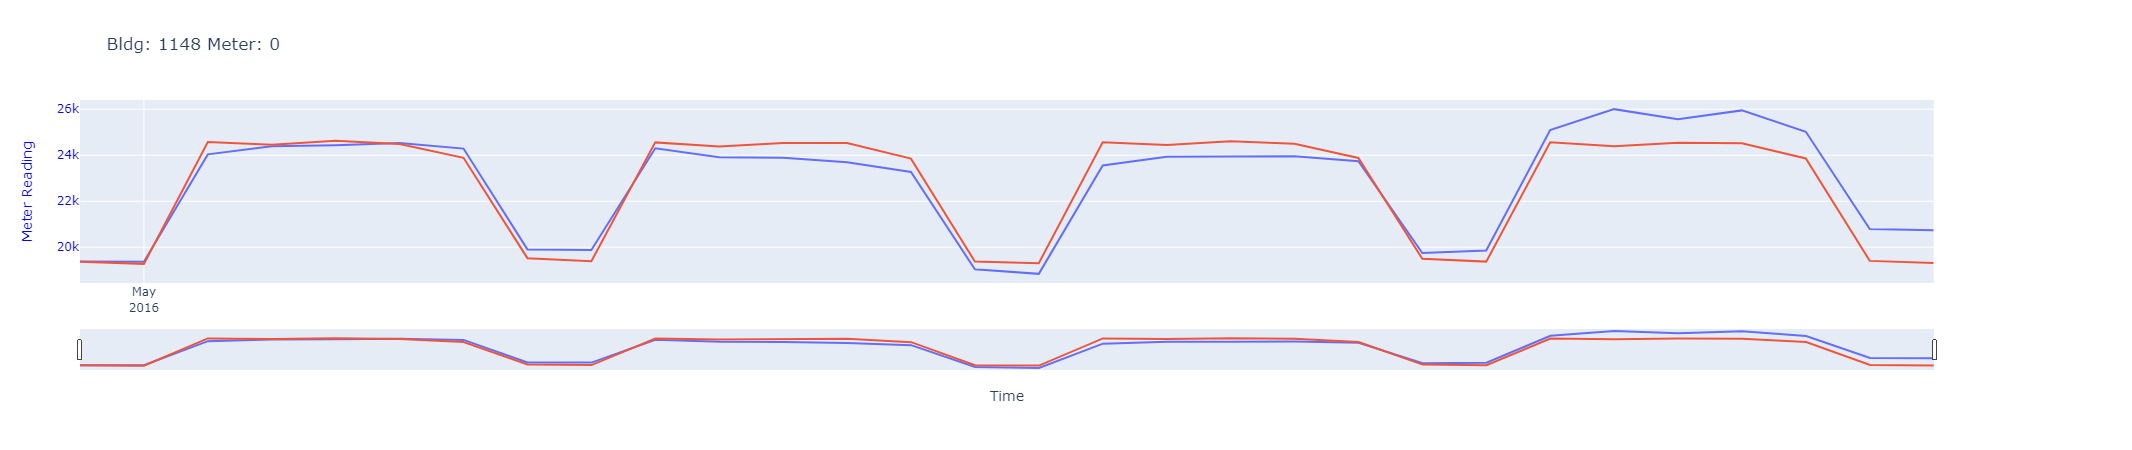

Data Size:  120
Train Size:  30
Offset:  60


DATA
Date Start: 
2016-03-01 00:00:00
Date End: 
2016-06-28 00:00:00


TRAIN
Date Start: 
2016-03-01 00:00:00
Date End: 
2016-05-29 00:00:00


TEST
Date Start: 
2016-05-30 00:00:00
Date End: 
2016-06-28 00:00:00


ARIMA Model: 
Model Fit: 


            ARIMA_predict  meter_reading
timestamp                               
2016-05-30       25333.70       20652.99
2016-05-31       25922.06       25435.85
2016-06-01       25482.25       24547.76
2016-06-02       25760.27       24023.71
2016-06-03       24954.63       24267.39
2016-06-04       20764.44       20646.21
2016-06-05       20744.47       20520.09
2016-06-06       25457.31       23373.42
2016-06-07       26106.44       23913.81
2016-06-08       25666.80       24215.74
2016-06-09       25965.06       25486.75
2016-06-10       25136.05       26178.63
2016-06-11       20938.44       22239.95
2016-06-12       20913.16       21853.55
2016-06-13       25602.61       25972.38
2016-06-14     

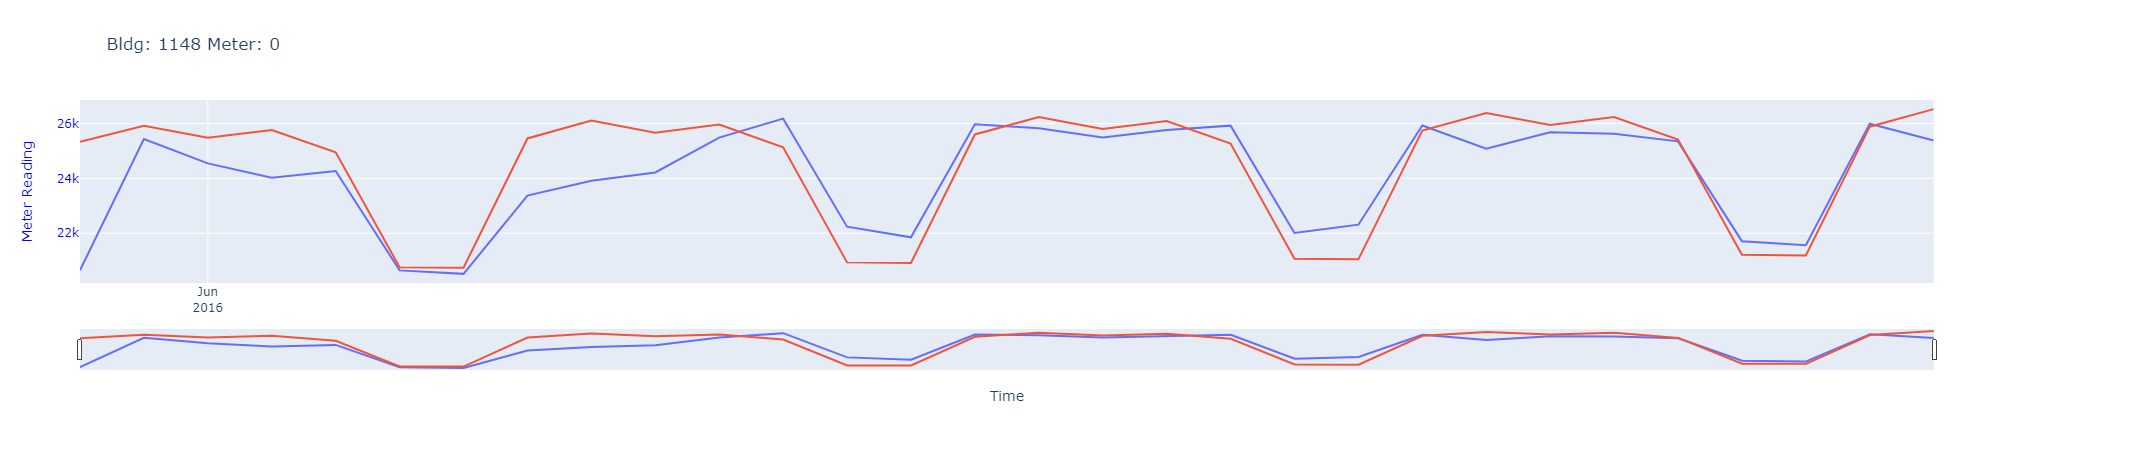

In [82]:
# Holes in the data
# Data is daily
offsets = [0,30,60] # offsets in days
data_sizes = [120]
test_sizes = [int(x * 0.25) for x in data_sizes]

resample = True

# df_results = pd.DataFrame(columns = ['TrainLen',
#                                      'TestLen',
#                                      'ARIMA_predict',
#                                      'ARIMA_actual'])

# For each of the file matches (did this way to prevent long run times)
for num,file in enumerate(files):
    print('-----------------------------------------------------------------------------')
 
    df_train = pd.read_pickle(file) # Show how many days 
    
    bldg_size = df_train.iloc[0]['square_feet']
    bldg_number = df_train.iloc[0]['building_id']
    bldg_meter = df_train.iloc[0]['meter']

    title = df_stats[(df_stats['building'] == bldg_number) & (df_stats['meter'] == bldg_meter)][['building',
                                                                                                 'meter',
                                                                                                 'per_data',
                                                                                                'category',
                                                                                                'square_feet',
                                                                                                'corr_meter_to_airtemp']]
    print(title)
 
    # RESAMPLE DATA
    if resample:
 
        agg_dict={'meter_reading':'sum', 
                  'air_temperature':'max',
                  'dew_temperature':'max',
                  'cloud_coverage':'mean',
                  'dew_temperature':'max',
                  'precip_depth_1_hr':'sum',
                  'sea_level_pressure':'mean',
                  'building_id': 'max',
                  'site_id': 'max'
                  }

        resamp = '1D'

        df_train = df_train.resample(resamp).agg(agg_dict)

    # Curently for 4 periods
    for ds, ts in zip(data_sizes,test_sizes):     
        for off in offsets:
            print('Data Size: ', ds)
            print('Train Size: ', ts)
            print('Offset: ', off)

            train, test = model_selection.train_test_split(df_train.iloc[off:off+ds], test_size=ts)
            df_slice = df_train.iloc[off:off+ds]
            
            print("\n" * 1)
            print('DATA')
            print('Date Start: ')
            print(df_slice.iloc[0].name)
            print('Date End: ')
            print(df_slice.iloc[-1].name)
            
            print("\n" * 1)
            print('TRAIN')
            print('Date Start: ')
            print(train.iloc[0].name)
            print('Date End: ')
            print(train.iloc[-1].name)
            
            print("\n" * 1)
            print('TEST')
            print('Date Start: ')
            print(test.iloc[0].name)
            print('Date End: ')
            print(test.iloc[-1].name)
            
            
            ######################################    ARIMA   ##################################################
            print("\n" * 1)
            print('ARIMA Model: ')
            print('Model Fit: ')
            
            # Create Pipeline Object
            pipe = pipeline.Pipeline([("arima", arima.AutoARIMA(trace=False, error_action="ignore",
                              seasonal=True,
                              suppress_warnings=True,m=7,
                             exogenous=df_train[['sea_level_pressure']]))])
                       
            pipe.fit(train['meter_reading'])

            print("\n" * 1)
            predict_meter, conf_int = pipe.predict(n_periods=ts, return_conf_int=True)
  
            predict_s = pd.Series(predict_meter,index=test.index,name='ARIMA_predict')          
            df_result = pd.concat([predict_s,test['meter_reading']],axis=1)
            print(df_result)
    
            error = ((sqrt(mean_squared_error(df_result['ARIMA_predict'],df_result['meter_reading']))))
            print('MSE: ' + str(error))
            
            ######################################   VISUALIZE #################################################
            subfig = make_subplots(specs=[[{"secondary_y": True}]])
            
            fig = px.line(df_result, x=df_result.index, y='meter_reading', 
                           title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter))
            
            fig2 = px.line(df_result, x=df_result.index, y='ARIMA_predict', 
                           title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter))

#             fig2.update_traces(yaxis="y1")

            subfig.add_traces(fig.data + fig2.data)
            subfig.layout.title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter)
            subfig.layout.xaxis.title="Time"
            subfig.layout.yaxis.title="Meter Reading"
            subfig.layout.yaxis.color="blue"

            subfig.update_xaxes(dtick="M1", tickformat="%b\n%Y")

            subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
            subfig.update_xaxes(rangeslider_visible=True)
            
            # Hover text for exploration
            subfig.update_traces(mode='lines',hovertemplate="%{x|%Y/%m/%d %a %H:%M:%S.%L} value: %{y}")
            subfig.update_layout(showlegend=True)
            subfig.write_image('.//visualization//' + str(bldg_number) + '_' + str(bldg_meter) + 'ARIMA_1reg.jpg')

            subfig.show()



# 2 - Build Model - Prophet

In [41]:
from prophet.plot import plot_plotly, plot_components_plotly

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-----------------------------------------------------------------------------
     building  meter  per_data category  square_feet  corr_meter_to_airtemp
193      1148      0    100.00   Office       861524                  -0.02
Data Size:  120
Train Size:  30
Offset:  0


DATA
Date Start: 
2016-01-01 00:00:00
Date End: 
2016-04-29 00:00:00


TRAIN
Date Start: 
2016-01-01 00:00:00
Date End: 
2016-03-30 00:00:00


TEST
Date Start: 
2016-03-31 00:00:00
Date End: 
2016-04-29 00:00:00
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2016-03-31 23613.50    19838.98    32068.03     23613.50     23613.50   
1  2016-04-01 23650.21    17848.71    29433.29     23650.21     23650.21   
2  2016-04-02 23686.92    13982.24    27085.56     23686.92     23686.92   
3  2016-04-03 23723.62    13929.70    26706.76     23723.62     23723.62   
4  2016-04-04 23760.33    18604.96    31186.21     23760.33     23760.33   
5  2016-04-05 23797.04    19159.79    31567.35     23797.

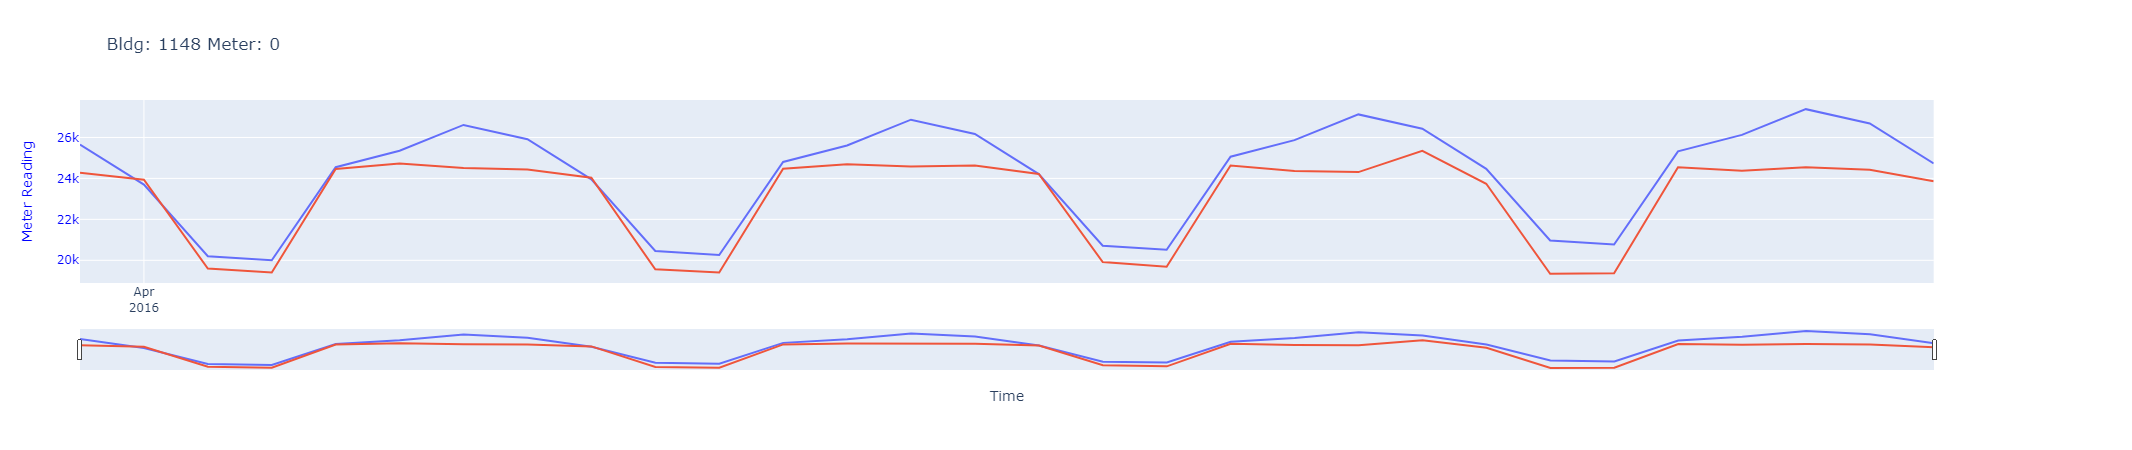

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 1358.2544995061937
Data Size:  120
Train Size:  30
Offset:  30


DATA
Date Start: 
2016-01-31 00:00:00
Date End: 
2016-05-29 00:00:00


TRAIN
Date Start: 
2016-01-31 00:00:00
Date End: 
2016-04-29 00:00:00


TEST
Date Start: 
2016-04-30 00:00:00
Date End: 
2016-05-29 00:00:00
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2016-04-30 23047.32    19403.44    20128.76     23047.03     23047.32   
1  2016-05-01 23046.60    19098.05    19870.49     23043.33     23049.35   
2  2016-05-02 23045.88    24085.92    24838.58     23037.02     23053.94   
3  2016-05-03 23045.15    24293.33    25081.29     23028.89     23061.12   
4  2016-05-04 23044.43    24151.43    24877.69     23020.69     23069.36   
5  2016-05-05 23043.71    24153.11    24900.00     23010.05     23078.25   
6  2016-05-06 23042.99    23490.42    24263.06     23000.48     23088.05   
7  2016-05-07 23042.27    19353.58    20132.25     22988.88     23096.41   
8  2016-05-08 23041.55    19076.30

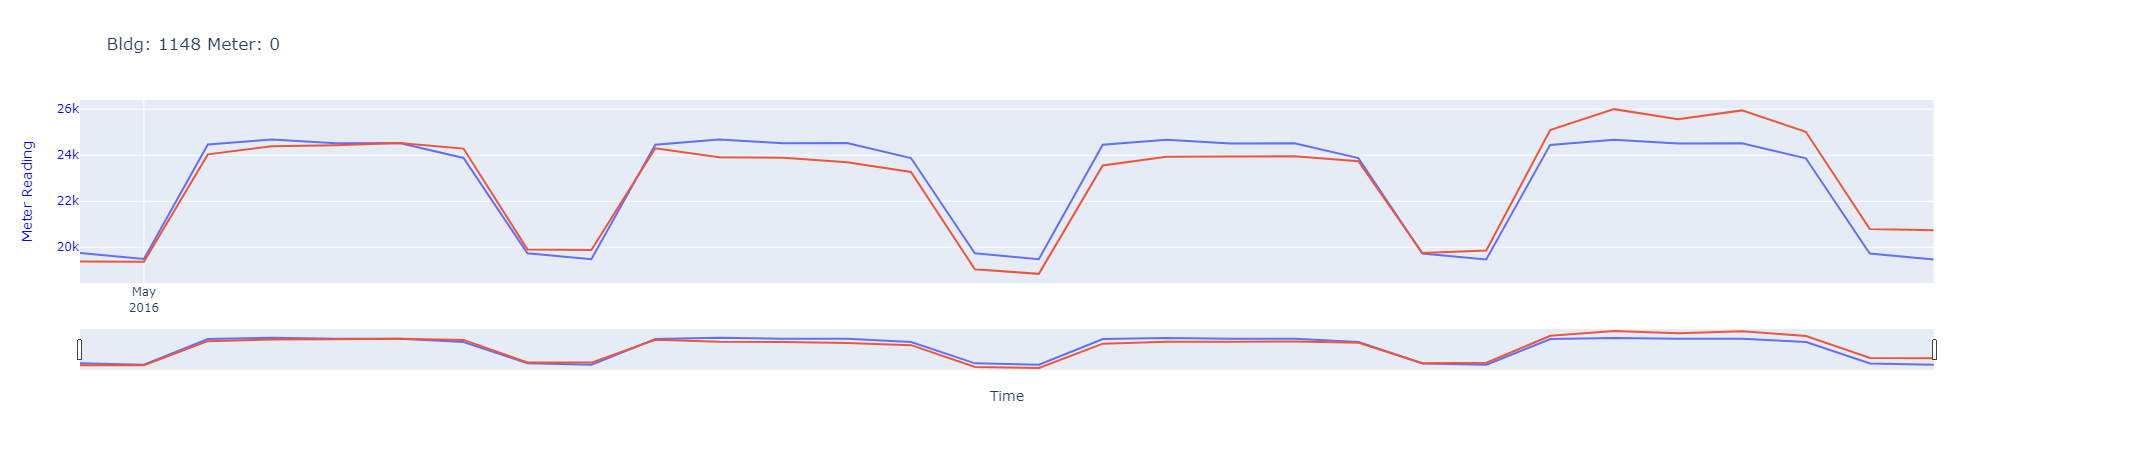

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 715.2630863459896
Data Size:  120
Train Size:  30
Offset:  60


DATA
Date Start: 
2016-03-01 00:00:00
Date End: 
2016-06-28 00:00:00


TRAIN
Date Start: 
2016-03-01 00:00:00
Date End: 
2016-05-29 00:00:00


TEST
Date Start: 
2016-05-30 00:00:00
Date End: 
2016-06-28 00:00:00
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2016-05-30 24073.23    24957.07    25951.94     24072.68     24074.16   
1  2016-05-31 24151.31    25306.46    26343.63     24146.46     24157.36   
2  2016-06-01 24229.39    25205.91    26218.68     24217.92     24245.11   
3  2016-06-02 24307.47    25284.86    26322.70     24286.22     24333.59   
4  2016-06-03 24385.55    24727.22    25756.38     24351.13     24421.44   
5  2016-06-04 24463.63    20639.22    21685.87     24412.99     24511.35   
6  2016-06-05 24541.71    20488.37    21516.51     24481.03     24603.28   
7  2016-06-06 24619.79    25513.82    26522.05     24542.61     24698.67   
8  2016-06-07 24697.87    25879.08 

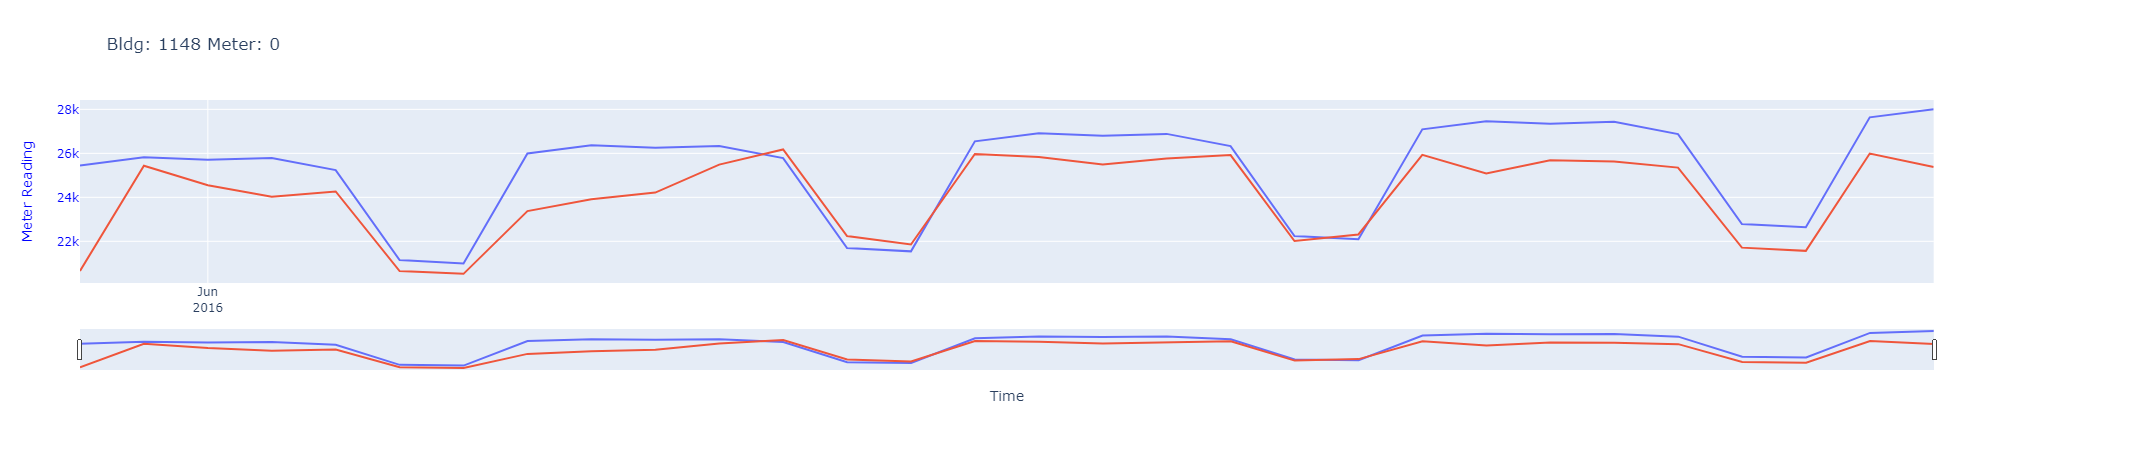

MSE: 1626.9604657932443


In [83]:
# Holes in the data
# Data is daily
offsets = [0,30,60] # offsets in days
data_sizes = [120]
test_sizes = [int(x * 0.25) for x in data_sizes]

resample = True

# For each of the file matches (did this way to prevent long run times)
for num,file in enumerate(files):
    print('-----------------------------------------------------------------------------')
 
    df_train = pd.read_pickle(file) # Show how many days 
    
    bldg_size = df_train.iloc[0]['square_feet']
    bldg_number = df_train.iloc[0]['building_id']
    bldg_meter = df_train.iloc[0]['meter']

    title = df_stats[(df_stats['building'] == bldg_number) & (df_stats['meter'] == bldg_meter)][['building',
                                                                                                 'meter',
                                                                                                 'per_data',
                                                                                                'category',
                                                                                                'square_feet',
                                                                                       'corr_meter_to_airtemp']]
    print(title)
 
    if resample:
    #     # Map of how we aggregate new data when it is resampled
        agg_dict={'meter_reading':'sum', 
                  'air_temperature':'max',
                  'dew_temperature':'max',
                  'cloud_coverage':'mean',
                  'dew_temperature':'max',
                  'precip_depth_1_hr':'sum',
                  'sea_level_pressure':'mean',
                  'building_id': 'max',
                  'site_id': 'max'
                  }

        resamp = '1D'

        df_train = df_train.resample(resamp).agg(agg_dict)

    # Curently for 4 periods
    for ds, ts in zip(data_sizes,test_sizes):     
        for off in offsets:
            print('Data Size: ', ds)
            print('Train Size: ', ts)
            print('Offset: ', off)

            train, test = model_selection.train_test_split(df_train.iloc[off:off+ds], test_size=ts)
            df_slice = df_train.iloc[off:off+ds]
            
            print("\n" * 1)
            print('DATA')
            print('Date Start: ')
            print(df_slice.iloc[0].name)
            print('Date End: ')
            print(df_slice.iloc[-1].name)
            
            print("\n" * 1)
            print('TRAIN')
            print('Date Start: ')
            print(train.iloc[0].name)
            print('Date End: ')
            print(train.iloc[-1].name)
            
            print("\n" * 1)
            print('TEST')
            print('Date Start: ')
            print(test.iloc[0].name)
            print('Date End: ')
            print(test.iloc[-1].name)
            
            
            ######################################    PROPHET   ##################################################

            m = Prophet()
            df_prophet_train = train.reset_index()

            df_prophet_train = df_prophet_train[['timestamp','meter_reading']]
            df_prophet_train = df_prophet_train.rename(columns={'timestamp':'ds','meter_reading':'y'})

            test2 = test
            df_prophet_test = test.reset_index()
            df_prophet_test = df_prophet_test[['timestamp','meter_reading']]
            df_prophet_test = df_prophet_test.rename(columns={'timestamp':'ds','meter_reading':'y'})

            df_prophet_predict = test.reset_index()
            df_prophet_predict = df_prophet_predict[['timestamp']]
            df_prophet_predict = df_prophet_predict.rename(columns={'timestamp':'ds'})

            
            m.fit(df_prophet_train)
            
            predicts = m.predict(df_prophet_test)
            print(predicts)

             ######################################   VISUALIZE #################################################
            subfig = make_subplots(specs=[[{"secondary_y": True}]])
            
            fig = px.line(predicts, x='ds', y='yhat', 
                           title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter))
            
            fig2 = px.line(test2, x=test2.index, y='meter_reading', 
                           title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter))

            fig2.update_traces(yaxis="y1")

            subfig.add_traces(fig.data + fig2.data)
            subfig.layout.title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter)
            subfig.layout.xaxis.title="Time"
            subfig.layout.yaxis.title="Meter Reading"
            subfig.layout.yaxis.color="blue"

            subfig.update_xaxes(dtick="M1", tickformat="%b\n%Y")

            subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
            subfig.update_xaxes(rangeslider_visible=True)
            

            # Hover text for exploration
            subfig.update_traces(mode='lines',hovertemplate="%{x|%Y/%m/%d %a %H:%M:%S.%L} value: %{y}")
            subfig.update_layout(showlegend=True)
            subfig.write_image('.//visualization//' + str(bldg_number) + '_' + str(bldg_meter) + 'Prophet.jpg')

            subfig.show()
            
            error = ((sqrt(mean_squared_error(predicts['yhat'],test2['meter_reading']))))
            print('MSE: ' + str(error))
    

# 3 - Build Model - XGBoost

In [81]:
# Holes in the data
# Data is daily
offsets = [0,30,60] # offsets in days
data_sizes = [120]
test_sizes = [int(x * 0.25) for x in data_sizes]

resample = True

# For each of the file matches (did this way to prevent long run times)
for num,file in enumerate(files):
    print('-----------------------------------------------------------------------------')
 
    df_train = pd.read_pickle(file) # Show how many days 
    
    bldg_size = df_train.iloc[0]['square_feet']
    bldg_number = df_train.iloc[0]['building_id']
    bldg_meter = df_train.iloc[0]['meter']

    title = df_stats[(df_stats['building'] == bldg_number) & (df_stats['meter'] == bldg_meter)][['building',
                                                                                                 'meter',
                                                                                                 'per_data',
                                                                                                'category',
                                                                                                'square_feet',
                                                                                       'corr_meter_to_airtemp']]
    print(title)
 
    if resample:
    #     # Map of how we aggregate new data when it is resampled
        agg_dict={'meter_reading':'sum', 
                  'air_temperature':'max',
                  'dew_temperature':'max',
                  'cloud_coverage':'mean',
                  'dew_temperature':'max',
                  'precip_depth_1_hr':'sum',
                  'sea_level_pressure':'mean',
                  'building_id': 'max',
                  'site_id': 'max'
                  }

        resamp = '1D'

        df_train = df_train.resample(resamp).agg(agg_dict)

    # Curently for 4 periods
    for ds, ts in zip(data_sizes,test_sizes):     
        for off in offsets:
            print('Data Size: ', ds)
            print('Train Size: ', ts)
            print('Offset: ', off)

            train, test = model_selection.train_test_split(df_train.iloc[off:off+ds], test_size=ts)
            df_slice = df_train.iloc[off:off+ds]
            
            print("\n" * 1)
            print('DATA')
            print('Date Start: ')
            print(df_slice.iloc[0].name)
            print('Date End: ')
            print(df_slice.iloc[-1].name)
            
            print("\n" * 1)
            print('TRAIN')
            print('Date Start: ')
            print(train.iloc[0].name)
            print('Date End: ')
            print(train.iloc[-1].name)
            
            print("\n" * 1)
            print('TEST')
            print('Date Start: ')
            print(test.iloc[0].name)
            print('Date End: ')
            print(test.iloc[-1].name)
            
            # Train is a dataframe
            
             ######################################    XGBOOST   ##################################################
             
            # Instantiate Model
            gbm = xgb.XGBRegressor(objective = 'reg:linear', n_estimators = 10, seed = 123)
            
            train_X = train['air_temperature'].reset_index(drop=True)
            train_y = train['meter_reading'].reset_index()
            test_X = test['air_temperature'].reset_index()
            test_y = test['meter_reading'].reset_index()
#             train_X = np.array(train['air_temperature'].fillna(0).values).reshape(1,-1)
#             train_y = np.array(train['meter_reading'].fillna(0).values).reshape(1,-1)
#             test_X = np.array(test['air_temperature'].fillna(0).values).reshape(1,-1)
#             test_y = np.array(train['meter_reading'].fillna(0).values).reshape(1,-1)
            
#             print(train['air_temperature'])
            

            print(train_X)
        
        
#             # Fitting the Model
#             gbm.fit(train_X,train_y)
#             pred = gbm.predict(train_X, train_y)

#             # RMSE Computation
#             rmse = np.sqrt(MSE(test_X, pred))
#             print("RMSE : % f" %(rmse))

             ######################################   VISUALIZE #################################################
#             subfig = make_subplots(specs=[[{"secondary_y": True}]])
            
#             fig = px.line(predicts, x='ds', y='yhat', 
#                            title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter))
            
#             fig2 = px.line(test2, x=test2.index, y='meter_reading', 
#                            title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter))

#             fig2.update_traces(yaxis="y1")

#             subfig.add_traces(fig.data + fig2.data)
#             subfig.layout.title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter)
#             subfig.layout.xaxis.title="Time"
#             subfig.layout.yaxis.title="Meter Reading"
#             subfig.layout.yaxis.color="blue"

#             subfig.update_xaxes(dtick="M1", tickformat="%b\n%Y")

#             subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
#             subfig.update_xaxes(rangeslider_visible=True)
            

#             # Hover text for exploration
#             subfig.update_traces(mode='lines',hovertemplate="%{x|%Y/%m/%d %a %H:%M:%S.%L} value: %{y}")
#             subfig.update_layout(showlegend=True)
#             subfig.write_image('.//visualization//' + str(bldg_number) + '_' + str(bldg_meter) + 'Prophet.jpg')

#             subfig.show()
            
#             error = ((sqrt(mean_squared_error(predicts['yhat'],test2['meter_reading']))))
#             print('MSE: ' + str(error))

-----------------------------------------------------------------------------
     building  meter  per_data category  square_feet  corr_meter_to_airtemp
193      1148      0    100.00   Office       861524                  -0.02
Data Size:  120
Train Size:  30
Offset:  0


DATA
Date Start: 
2016-01-01 00:00:00
Date End: 
2016-04-29 00:00:00


TRAIN
Date Start: 
2016-01-01 00:00:00
Date End: 
2016-03-30 00:00:00


TEST
Date Start: 
2016-03-31 00:00:00
Date End: 
2016-04-29 00:00:00
0    -1.10
1    -0.60
2    -2.20
3    -2.80
4     0.00
      ... 
85   10.00
86    7.80
87   14.40
88   16.70
89   13.90
Name: air_temperature, Length: 90, dtype: float64
Data Size:  120
Train Size:  30
Offset:  30


DATA
Date Start: 
2016-01-31 00:00:00
Date End: 
2016-05-29 00:00:00


TRAIN
Date Start: 
2016-01-31 00:00:00
Date End: 
2016-04-29 00:00:00


TEST
Date Start: 
2016-04-30 00:00:00
Date End: 
2016-05-29 00:00:00
0     5.00
1     2.80
2    -1.10
3    -2.20
4    -3.30
      ... 
85   13.90
86   10

## Time Series Split Cross Validation

In [ ]:
tss =  TimeSeriesSplit(n_splits=4,gap=4,test_size=14,max_train_size=120) #too generic
rmse = []
count = 1

results = pd.DataFrame()


# Write function that rolls next pd.delta?

for train_index, test_index in tss.split(df_train): 
    
    cv_train, cv_test = df_train.iloc[train_index]['meter_reading'], df_train.iloc[test_index]['meter_reading']
    model = pm.auto_arima(cv_train,trace=True,n_fits=20)
    print(model.summary())
    
    # 
    predicts = model.predict(n_periods=14)
    true_values = cv_test.values
    error = ((sqrt(mean_squared_error(predicts,true_values))))
    model.plot_diagnostics()
    rmse.append(error)
    print(error)
print('RMSE')
print(np.mean(rmse))

In [ ]:
df_tyra
print(model.summary())

# 
predicts = model.predict(n_periods=14)
true_values = cv_test.values
error = ((sqrt(mean_squared_error(predicts,true_values))))
model.plot_diagnostics()
rmse.append(error)
print(error)

In [ ]:
train.plot()

In [ ]:
test.plot()

In [ ]:
model.predict(n_periods=20)

In [ ]:

#                      start_p=1,max_p=7,
#                      start_q=1,max_q=7,
#                      start_P=1,max_P=7,
#                      start_Q=1,max_Q=7,
preds = model.predict(n_periods=test.shape[0], return_conf_int=False)

# cv = model_selection.SlidingWindowForecastCV(window_size=3,step=1,h=4)
# predictions = model_selection.cross_val_predict(model, test, cv=cv, verbose=2, averaging='median')
# # temp_model_cv_scores = model_selection.cross_val_score(model, train, scoring='smape', cv=cv, verbose=2)

# pred = pd.Series(predictions)
# df_temp_preds = pd.DataFrame(pred,index=test.index,columns=['predictions'])
# df_preds =pd.concat([df_temp_preds,test],axis=1)
# df_preds

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))


# Plot Forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 2016  # Year starts at 1821

plt.plot(preds,kind='line')

In [ ]:

model.plot_diagnostics()

In [ ]:
model

In [ ]:
preds

In [ ]:
model

In [ ]:
preds

In [ ]:
df_temp_preds = pd.DataFrame(preds,index=test.index,columns=['predictions'])
df_preds =pd.concat([df_temp_preds,test],axis=1)
df_preds

In [ ]:
# Plot Forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 2016  # Year starts at 1821

plt.plot(df_preds,kind='line')

# plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
#                  conf_int[:, 0], conf_int[:, 1],
#                  alpha=0.1, color='b')
# plt.title("Temperature Forecast")
# plt.xlabel("Year")

# ARIMA

### Set PDQ

# Rolling Forecast ARIMA
### Walk-forward validation

### Grid Search ARIMA / Evaluation

# Facebook Prophet
## Additive Time Series Forecasting Model

In [ ]:
from fbprophet import Prophet

In [ ]:
data_len = 366
split_test_doy = 270

df_train = df.iloc[0:split_test_doy]
df_test = df.iloc[split_test_doy:data_len]

In [ ]:
df_prophet_train = df_train.reset_index()
df_prophet_train = df_prophet_train[['timestamp','meter_reading']]
df_prophet_train = df_prophet_train.rename(columns={'timestamp':'ds','meter_reading':'y'})

df_prophet_test = df_test.reset_index()
df_prophet_test = df_prophet_test[['timestamp','meter_reading']]
df_prophet_test = df_prophet_test.rename(columns={'timestamp':'ds','meter_reading':'y'})

df_prophet_predict = df_test.reset_index()
df_prophet_predict = df_prophet_predict[['timestamp']]
df_prophet_predict = df_prophet_predict.rename(columns={'timestamp':'ds'})


In [ ]:
model = Prophet()
model.fit(df_prophet_train)

In [ ]:
df_forecast = model.predict(df_prophet_predict)

In [ ]:
print(df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

In [ ]:
model.plot(forecast)